GREAT: Reproject Data to GREAT Resolution
================
* **Aim**: Re-project RGB WISE image data onto GREAT pixel map. <br />
* **Data**: Level 3 data. <br />
* **Tools**: astropy <br />
* **Instrument**: GREAT <br />
* **Documentation**: [GREAT observer's handbook](https://irsa.ipac.caltech.edu/data/SOFIA/docs/instruments/great/)

Goals
-------
* Plot WISE data
* Reproject WISE data to pixel map of GREAT data
* Create RGB image with three WISE images
* Reproject RGB WISE image to pixel map of GREAT data

Introduction
--------------

This recipe is a tutorial for reprojecting data from other observatories to the to the pixel map of GREAT data to better compare the data.

Imports 
---------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from reproject import reproject_exact
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import get_pkg_data_filename
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

Ingredients
---------------

The data come from the [C II Maps in Massive Star Formation Regions](https://irsa.ipac.caltech.edu/data/SOFIA/docs/data/legacy-programs/radiative-and-mechanical-feedback-regions-massive-star-formation/index.html) from the FEEDBACK survey and target the emission nebula RCW 120. 

#### The slice of the GREAT data used in this tutorial can be downloaded directly [here](https://zenodo.org/record/6574619/files/FEEDBACK_RCW120_GREAT_example_subset.fits?download=1), 

You can download the full Level 4 dataset via the [IRSA archive](https://irsa.ipac.caltech.edu/Missions/sofia.html) using the program_ID: 07_0077.

The WISE data also come from the IRSA archive via the [WISE search page](https://irsa.ipac.caltech.edu/Missions/wise.html).

In [2]:
# Load data
hdu_great = fits.open(
    "example_data/GREAT/FEEDBACK_RCW120_GREAT_example_subset.fits"
)  # Read datacube

In [3]:
hdu_great.info()

Filename: example_data/GREAT/FEEDBACK_RCW120_GREAT_example_subset.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      94   (143, 144, 120)   float64   


The GREAT data is a 3D data cube but we are only interested in the 2D WCS information in this example. To flatten the 3D datacube we delete the fits header keywords related to the third dimension and set the GREAT data to only one 2D slice. 

Text(0.5, 1.0, 'GREAT slice 60')

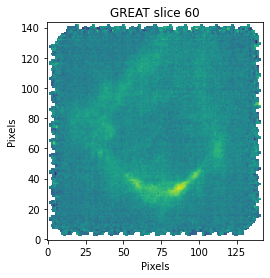

In [4]:
# plot a slice of the GREAT data

# choose slice
great_slice = 60

# plot data
fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(111)
# origin is where to set the [0,0] pixel
ax1.imshow(hdu_great[0].data[great_slice], origin="lower")
ax1.set_xlabel("Pixels")
ax1.set_ylabel("Pixels")
ax1.set_title("GREAT slice 60")

In [5]:
# remove 3rd dimension WCS information, flattening the image
hdu_great[0].header["NAXIS"] = 2

keywords_to_delete = [
    "NAXIS3",
    "CTYPE3",
    "CRVAL3",
    "CDELT3",
    "CRPIX3",
    "CROTA3",
#     "CUNIT3",
]

for item in keywords_to_delete:
    del hdu_great[0].header[item]

# store new WCS info
wcs_great_flattened = WCS(hdu_great[0].header)

# set GREAT data as only one 2D slice
hdu_great[0].data = hdu_great[0].data[great_slice]

Text(0.5, 1.0, 'Original WISE data')

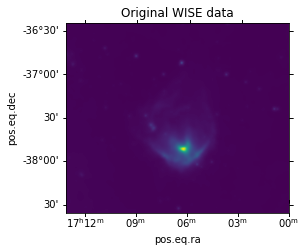

In [6]:
# plot the data we want to re-project
hdu_wise = fits.open("example_data/GREAT/rcw_120_WISE/RWC120_WISE4.fits")
fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(111, projection=wcs_great_flattened)
ax1.imshow(hdu_wise[0].data)
ax1.set_title("Original WISE data")

In [7]:
# Calculate new pixel map for WISE data using GREAT WCS information
reproj_wise, footprint = reproject_exact(hdu_wise, hdu_great[0].header)
hdu_wise[0].header.update(wcs_great_flattened.to_header())

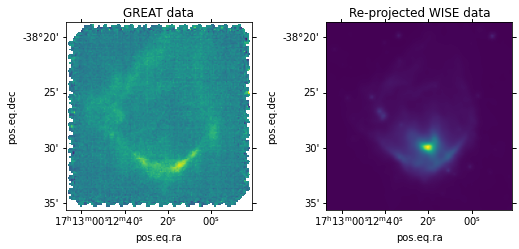

In [8]:
# plot GREAT data and new WISE reprojection
fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121, projection=wcs_great_flattened)
ax2 = plt.subplot(122, projection=wcs_great_flattened, sharex=ax1, sharey=ax1)
ax1.imshow(hdu_great[0].data)
ax2.imshow(reproj_wise)
ax1.set_title("GREAT data")
ax2.set_title("Re-projected WISE data")
plt.subplots_adjust(wspace=0.4, hspace=0)
plt.show()

## Create an RGB image 

In [9]:
r = fits.open("example_data/GREAT/rcw_120_WISE/RWC120_WISE4.fits")
g = fits.open("example_data/GREAT/rcw_120_WISE/RWC120_WISE2.fits")
b = fits.open("example_data/GREAT/rcw_120_WISE/RWC120_WISE1.fits")

In [10]:
# determining a better color scle using the top and bottom 2.5% intervals
lower_val, upper_val = np.percentile(
    np.hstack((r[0].data.flatten(), g[0].data.flatten(), b[0].data.flatten())),
    (2.5, 97.5),
)
stretch_val = upper_val - lower_val

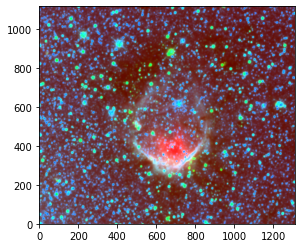

In [11]:
# create rgb image
rgb_data = make_lupton_rgb(
    r[0].data * 0.8,
    g[0].data * 2,
    b[0].data * 1.5,
    minimum=lower_val,  # minimum value
    stretch=stretch_val,  # linear stretch of image
    Q=1,  # asinh softening parameter
)

# plot image
plt.imshow(rgb_data, origin="lower")

## Re-project RGB image

In [12]:
# reproject each of the three images in the same way as above
reproj_r, _ = reproject_exact(r, hdu_great[0].header)
r[0].header.update(wcs_great_flattened.to_header())

reproj_g, _ = reproject_exact(g, hdu_great[0].header)
g[0].header.update(wcs_great_flattened.to_header())

reproj_b, _ = reproject_exact(b, hdu_great[0].header)
b[0].header.update(wcs_great_flattened.to_header())

In [13]:
# make re-projected RGB image
rgb_reproj = make_lupton_rgb(
    reproj_r * 0.8,
    reproj_g * 2,
    reproj_b * 1.5,
    minimum=lower_val,
    stretch=stretch_val,
    Q=1,
)

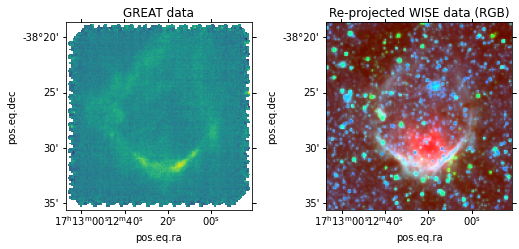

In [14]:
# plot new RGB image
fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121, projection=wcs_great_flattened)
ax2 = plt.subplot(122, projection=wcs_great_flattened, sharex=ax1, sharey=ax1)
ax1.imshow(hdu_great[0].data)
ax2.imshow(rgb_reproj, origin="lower")
ax1.set_title("GREAT data")
ax2.set_title("Re-projected WISE data (RGB)")
plt.subplots_adjust(wspace=0.4, hspace=0)
plt.show()